In [1]:
# Import required packages
using Lux                  # Neural network definition and training
using LuxCUDA
using TaylorDiff           # Automatic differentiation
using Optimization         # Optimization problem solving
using Optimisers           # Optimizers such as Adam
using Random               # Random number generation
using Plots                # Plotting utilities
using Zygote               # Automatic differentiation
using ComponentArrays      # Array utilities for handling model parameters
using Printf               # Advanced formatted printing
using LinearAlgebra        # Linear algebra operations
using Statistics           # Statistical operations
using OptimizationOptimisers  # Optimization extensions for Optimisers
using OptimizationOptimJL     # Optimization extensions for LBFGS

In [2]:
# Initial program setup
# Seeding for reproducibility
rng = Random.default_rng()
Random.seed!(rng, 0)

TaskLocalRNG()

In [3]:
# Device configuration (CPU/GPU)
const DEVICE_CPU = cpu_device()  # CPU device
const DEVICE_GPU = gpu_device()  # GPU device (if available)

(::CUDADevice{Nothing}) (generic function with 1 method)

In [4]:
# Data preparation
# Input range and target output
const INPUT_RANGE = range(-5f0, 5f0, length=100)
input_data = reshape(collect(INPUT_RANGE), 1, :)  |> DEVICE_GPU# Input data
true_output = reshape(Float32.(sin.(input_data)), 1, :)  # Target output
data = (input_data, true_output) |> DEVICE_GPU  # Move data to the selected device

(Float32[-5.0 -4.8989897 … 4.8989897 5.0], Float32[0.9589243 0.98264056 … -0.98264056 -0.9589243])

In [5]:
# Reference function definition
target_function(x) = sin.(x)

target_function (generic function with 1 method)

In [6]:
# Neural network definition
# Architecture: Network with multiple dense layers and tanh activation
const HIDDEN_UNITS = 100
model = Chain(
    Dense(1 => HIDDEN_UNITS, tanh),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => 1)
)

Chain(
    layer_1 = Dense(1 => 100, tanh),    # 200 parameters
    layer_2 = Dense(100 => 100, tanh),  # 10_100 parameters
    layer_3 = Dense(100 => 100, tanh),  # 10_100 parameters
    layer_4 = Dense(100 => 100, tanh),  # 10_100 parameters
    layer_5 = Dense(100 => 1),          # 101 parameters
)         # Total: 30_601 parameters,
          #        plus 0 states.

In [7]:
# Model initialization
params, states = Lux.setup(rng, model)  # Initial parameters and states
params = ComponentArray(params) |> DEVICE_GPU  # Move parameters to the device
states = states |> DEVICE_GPU  # Move states to the device
smodel = StatefulLuxLayer{true}(model, params, states)  # Stateful model layer


StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(1 => 100, tanh),  # 200 parameters
        layer_2 = Dense(100 => 100, tanh),  # 10_100 parameters
        layer_3 = Dense(100 => 100, tanh),  # 10_100 parameters
        layer_4 = Dense(100 => 100, tanh),  # 10_100 parameters
        layer_5 = Dense(100 => 1),      # 101 parameters
    ),
)         # Total: 30_601 parameters,
          #        plus 0 states.

In [8]:
# Callback function
# Monitors training progress
function callback(state, l)
    state.iter % 100 == 1 && @printf "Iteration: %5d, Loss: %.6e\n" state.iter l
    return l < 1e-8  # Stop if loss is sufficiently small
end

callback (generic function with 1 method)

In [9]:
# Definir el valor de ε1
εmachine = eps(Float32)
ε1 = εmachine^(1/3)

# Función de pérdida
# Usa el método adjunto para el cálculo del gradiente
function loss_adjoint(params, (input_data, true_output))
    # Predicción de la red neuronal
    f(input_data) = smodel(input_data, params)
    
    # Calcular la derivada numérica usando diferencias finitas centradas
    ∂u_∂x(input_data) = (f(input_data .+ ε1) .- f(input_data .- ε1)) / (2 * ε1)
    
    # Predicción de la derivada
    pred = ∂u_∂x(input_data)
    
    # Calcular la pérdida
    loss1 = mean((pred .- true_output).^2)  # Error cuadrático medio
    loss2 = mean((f([0f0] |> DEVICE_GPU) .- (-1f0)).^2)  # Error cuadrático medio en el punto 0
    loss = loss1 + loss2
    
    return loss
end

# Definir el problema de optimización
opt_func = OptimizationFunction(loss_adjoint, Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, params, data)
epochs = 1_000  # Número máximo de iteraciones


1000

In [10]:
# Train using the Adam optimizer
res_adam = solve(opt_prob, Optimisers.Adam(0.001), callback=callback, maxiters=epochs)

┌ Warning: Mixed Precision Inputs received for `weight`: CuArray{Float32, 2, CUDA.DeviceMemory} and `x`: CuArray{Float64, 2, CUDA.DeviceMemory}. Promoting to Float64.
└ @ LuxLibCUDAExt /home/orincon/.julia/packages/LuxLib/ru5RQ/ext/LuxLibCUDAExt/cublaslt.jl:26


Iteration:     1, Loss: 1.691857e+00
Iteration:   101, Loss: 1.346181e-01
Iteration:   201, Loss: 4.331442e-03
Iteration:   301, Loss: 4.142685e-04
Iteration:   401, Loss: 2.271124e-04
Iteration:   501, Loss: 1.810840e-04
Iteration:   601, Loss: 1.579163e-04
Iteration:   701, Loss: 1.367104e-04
Iteration:   801, Loss: 1.510648e-04
Iteration:   901, Loss: 9.236083e-04


retcode: Default
u: ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:200, Axis(weight = ViewAxis(1:100, ShapedAxis((100, 1))), bias = 101:200)), layer_2 = ViewAxis(201:10300, Axis(weight = ViewAxis(1:10000, ShapedAxis((100, 100))), bias = 10001:10100)), layer_3 = ViewAxis(10301:20400, Axis(weight = ViewAxis(1:10000, ShapedAxis((100, 100))), bias = 10001:10100)), layer_4 = ViewAxis(20401:30500, Axis(weight = ViewAxis(1:10000, ShapedAxis((100, 100))), bias = 10001:10100)), layer_5 = ViewAxis(30501:30601, Axis(weight = ViewAxis(1:100, ShapedAxis((1, 100))), bias = 101:101)))}}}(layer_1 = (weight = Float32[2.3510897; 0.29029527; … ; 0.05203672; -1.7380482;;], bias = Float32[-0.29110494, 0.80720717, 0.4746107, 0.31136593, -0.1756162, 0.5487866, 0.88410026, 0.55902916, -0.9936952, 0.10770957  …  -0.732083, -0.7848709, -0.8559289, -0.3054592, 0.026783263, 0.24711275, 0.1770735, -0.9418186, 0.604123, 0.73950124]), layer_2 = (weight = Float32[-0.

In [11]:
# Redefine the optimization problem with updated parameters
opt_prob = OptimizationProblem(opt_func, res_adam.u, data)

# Further training using the LBFGS optimizer
res_lbfgs = solve(opt_prob, LBFGS(); callback, maxiters=epochs)

Iteration:     1, Loss: 1.098330e-04
Iteration:   101, Loss: 2.955175e-05
Iteration:   201, Loss: 1.783667e-05
Iteration:   301, Loss: 1.060319e-05
Iteration:   401, Loss: 8.103667e-06
Iteration:   501, Loss: 6.596141e-06
Iteration:   601, Loss: 4.090919e-06
Iteration:   701, Loss: 2.853274e-06
Iteration:   801, Loss: 1.742129e-06
Iteration:   901, Loss: 1.599707e-06


retcode: Failure
u: ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:200, Axis(weight = ViewAxis(1:100, ShapedAxis((100, 1))), bias = 101:200)), layer_2 = ViewAxis(201:10300, Axis(weight = ViewAxis(1:10000, ShapedAxis((100, 100))), bias = 10001:10100)), layer_3 = ViewAxis(10301:20400, Axis(weight = ViewAxis(1:10000, ShapedAxis((100, 100))), bias = 10001:10100)), layer_4 = ViewAxis(20401:30500, Axis(weight = ViewAxis(1:10000, ShapedAxis((100, 100))), bias = 10001:10100)), layer_5 = ViewAxis(30501:30601, Axis(weight = ViewAxis(1:100, ShapedAxis((1, 100))), bias = 101:101)))}}}(layer_1 = (weight = Float32[2.350812; 0.31448227; … ; 0.16007502; -1.7334248;;], bias = Float32[-0.28791115, 0.8367013, 0.47348258, 0.31182772, -0.1764592, 0.546696, 0.97244394, 0.5586711, -0.99437416, 0.10925019  …  -0.7366093, -0.77991354, -0.8535383, -0.31115687, 0.024477255, 0.24746548, 0.29962215, -0.9446559, 0.586295, 0.74437344]), layer_2 = (weight = Float32[-

In [12]:
# Make predictions with the optimized model
pred = smodel(input_data, res_lbfgs.u)

1×100 CuArray{Float32, 2, CUDA.DeviceMemory}:
 -0.28347  -0.185237  -0.0853509  …  -0.0850643  -0.18491  -0.283282

In [22]:
# Compute the L2 error
error = LinearAlgebra.norm(pred .+ cos.(input_data), 2)
@printf "Error: %.5g\n" error

Error: 0.0019932


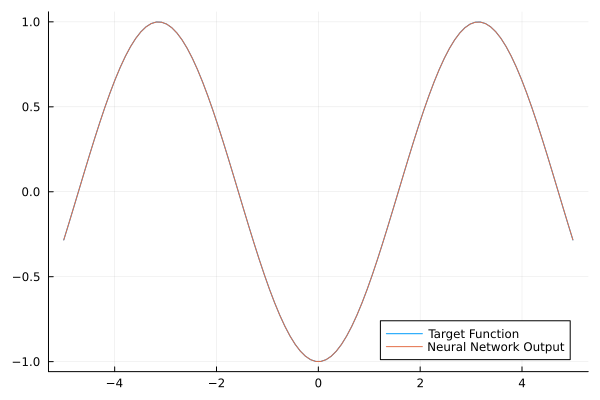

In [23]:
# Visualization of results
plot(Array(input_data)', Array(-cos.(input_data))', label="Target Function")
plot!(Array(input_data)', Array(pred)', label="Neural Network Output")